In [35]:
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
fs_923_df = pd.read_csv('../data/fs_sept.csv')
ce5_923_df = pd.read_csv('../data/ce5_sept.csv')
ce6_923_df = pd.read_csv('../data/ce6_sept.csv')
ce5_923_df['4'] = ce5_923_df['4'].str.extract(r'(\d)')
ce5_923_df['4'] = pd.to_numeric(ce5_923_df['4'], errors='coerce')
ce5_923_df['0'] = pd.to_datetime(ce5_923_df['0'], format='%Y-%m-%dT%H:%M:%S')
ce6_923_df['4'] = ce6_923_df['4'].str.extract(r'(\d)')
ce6_923_df['4'] = pd.to_numeric(ce6_923_df['4'], errors='coerce')
ce6_923_df['0'] = pd.to_datetime(ce6_923_df['0'], format='%Y-%m-%dT%H:%M:%S')

In [49]:
begin_load_df = fs_923_df[fs_923_df['PARTITION'] == 'production']\
                    [['BEGIN', 'USEDMEM', 'CPUS']].rename(columns={'BEGIN':'TIME'})
begin_load_df['USEDMEM'] = pd.to_numeric(begin_load_df['USEDMEM'].str[:-1], errors='coerce')
begin_load_df['CPUS'] = pd.to_numeric(begin_load_df['CPUS'], errors='coerce')

end_load_df = fs_923_df[fs_923_df['PARTITION'] == 'production']\
                    [['END', 'USEDMEM', 'CPUS']].rename(columns={'END':'TIME'})
# Since ending the process gives back the memory make all this values negative
end_load_df['USEDMEM'] = 0 - pd.to_numeric(end_load_df['USEDMEM'].str[:-1], errors='coerce')
end_load_df['CPUS'] = 0 - pd.to_numeric(end_load_df['CPUS'], errors='coerce')
load_df = begin_load_df.append(end_load_df).fillna(0)
load_df = load_df[load_df['TIME'].str.match(r'2021-09')].sort_values('TIME')
load_df['TIME'] = pd.to_datetime(load_df['TIME'], format='%Y-%m-%dT%H:%M:%S')

In [66]:
resample_interval = "30T"
fs_ts = pd.Series(list(load_df['USEDMEM']), index=list(load_df['TIME']))
a = fs_ts.resample(resample_interval).sum().to_frame().cumsum()
b = ce5_923_df.set_index('0').resample(resample_interval).sum()*10000000
c = ce6_923_df.set_index('0').resample(resample_interval).sum()*10000000
c = c.rename(columns={'4':'errorcode'})
a = a.join(b)
a = a.join(c)
a[0] = a[0] - a[0].min() # add the min value to all values to reset baseline

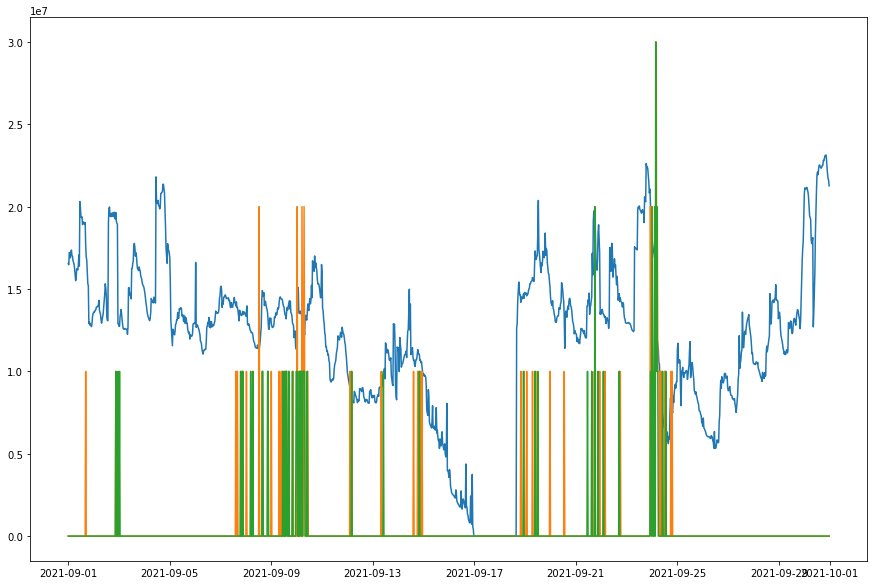

In [67]:
plt.figure(figsize=(15, 10))
plt.plot(a.index, a[0])
plt.plot(a.index, a['4'])
plt.plot(a.index, a['errorcode'])